# CosmoDC2: The Movie (feat. Apache Spark)

<br> Kernel: **desc-pyspark**
<br> Author: **LAL team**
<br> Last Verified to Run: **2018-12-20**
    
The goal of this notebook is to have a first 3D look at the latest DC2 extragalatic catalog (v1.1.4) using Apache Spark.
The use of Jupyter notebook at NERSC being (currently) memory limited, is not necessarily the best suited to do that, but may be used for local data visualization.
It is also an opportunity to help people learning Apache Spark while both enjoying the beauty of 3D displays.

Finally it can be seen as the making-of the future awards-winning COSMO-DC2 movie!

**Logistics:** 

This notebook is intended to be run through the JupyterHub NERSC interface with the desc-pyspark kernel. The kernel is automatically installed in your environment when you use the kernel setup script:

```bash
source /global/common/software/lsst/common/miniconda/kernels/setup.sh
```

In [4]:
from time import time

# For plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

# Reading parquet data

### Initialisation

Let's first initialise our Apache Spark session, and set up a simple timer to benchmark performances.

In [5]:
# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

#usefull class to benchmark
class Timer:
    """ A simple class for printing elapsed time (s) since last call
    """
    def __init__(self):
        self.t0 = time()
    
    def start(self):
        self.t0 = time()
        
    def stop(self):
        t1 = time()
        print("{:2.1f}s".format(t1 - self.t0))

timer = Timer()

spark session started


### Load the extra-galactic catalog

A key point here is that Apache Spark uses **lazy evaluation** when reading data so that nothing is actually loaded in memory: only headers are read. Real loading appears later, for instance when data are put in cache and an action is triggered.

For more on this important subject see e.g. https://arxiv.org/abs/1807.03078

In [6]:
timer.start()

# Path to cosmoDC2 (parquet format)
filename = "/global/cscratch1/sd/plaszczy/CosmoDC2/xyz_v1.1.4.parquet"

# Spark DataFrame
df_all = spark.read.parquet(filename)

# Le's inspect the schema of the data
df_all.printSchema()

timer.stop()

root
 |-- size_true: float (nullable = true)
 |-- position_x: float (nullable = true)
 |-- redshift_true: float (nullable = true)
 |-- position_y: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- is_central: boolean (nullable = true)
 |-- halo_id: long (nullable = true)
 |-- ra: float (nullable = true)
 |-- redshift: float (nullable = true)
 |-- position_z: float (nullable = true)

7.5s


Note: Apache Spark has no efficient PySpark connector to read data in hdf5 file. Therefore we first converted the cosmoDC2 data set into parquet (similar to what DPDD tools offer). For the purpose of this notebook, we only convert a few columns of interest. The file is accessible at NERSC for DESC members.

### Reject faint galaxies and put relevant quantities in cache

for a nicer look we reject faint galaxies that do have negative `halo_id` and keep only spatial positions. Then we load and cache in memory some relavant quantities. Finally we count how many galaxies remain. Note that only the final _action_ (`count`) triggers the whole computation. The order of _transformations_ (`select`, `filter`, ...) does not matter as Spark is produces an optimized version of the whole chain prior to perform the action. 

In [7]:
timer.start()

# Create a new dataframe selecting only interesting columns
# and keep only entries with positive halo_id.
cols = ["halo_id", "position_x", "position_y", "position_z", "redshift"]
cond = "halo_id > 0"
df = df_all.select(cols).filter(cond)

# We do not need halo_id anymore, so le's drop it
df = df.drop("halo_id")

# Put the data in cache for speeding up later use 
# and trigger an action (count). 
# This is the longer step but must be executed only once!
N = df.cache().count()

print("Number of galaxies={} M".format(N / 1e6))
timer.stop()

Number of galaxies=42.056819 M
10.6s


### Get some basic statistics

DataFrames have built-in tools to quickly inspect the data distribution, for each column:

In [8]:
timer.start()

# describe() returns a DataFrame
stat = df.describe()
stat.show()

timer.stop()

+-------+------------------+------------------+-------------------+------------------+
|summary|        position_x|        position_y|         position_z|          redshift|
+-------+------------------+------------------+-------------------+------------------+
|  count|          42056819|          42056819|           42056819|          42056819|
|   mean|1061.7103202557093|2310.9277070853323|-2103.0688513163377|1.7463885254211036|
| stddev| 316.7952573809094| 646.3027528174126|   599.051268789846|0.6995483636668913|
|    min|         1.2040268|         2.2592654|         -3366.6572|      8.8898395E-4|
|    max|         1819.9827|         3522.6223|         -2.1424696|         3.1173894|
+-------+------------------+------------------+-------------------+------------------+

1.7s


### Redshift histogram

Let's look at the distribution of redshifts.
This is slightly more technical (for details see: https://arxiv.org/abs/1807.03078 ), but it is extremely efficient for large dataset and will directly scale when (much) more data will be available, outperforming traditional tools.

2.0s


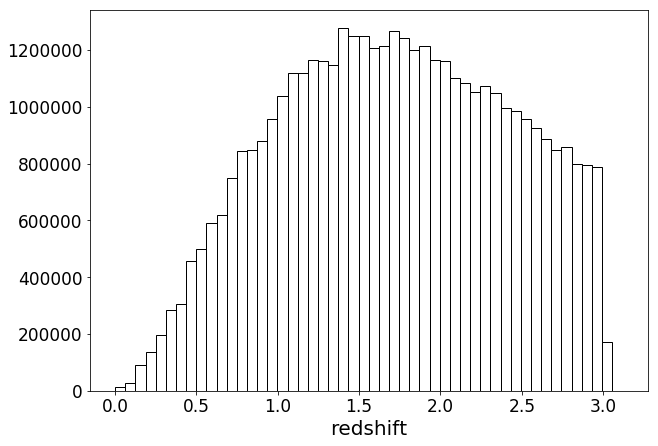

In [9]:
matplotlib.rcParams.update({'font.size': 17})
timer.start()

# Get min/max redshift values
m = df.select(F.min("redshift"), F.max("redshift")).first()
zmin, zmax = m[0], m[1]

# Number of bins, and spacings for our histogram
Nbins = 50
dz = (zmax - zmin) / Nbins
step = (zmax - zmin) / Nbins

# Add a columns of bins values
zbin = df.select(
    df["redshift"], 
    ((df["redshift"] - zmin - dz / 2) / dz).cast(IntegerType()).alias('bin'))

# GroupBy this column + count how many in each group (= histogram)
h = zbin.groupBy("bin").count().orderBy(F.asc("bin"))

# Add column of bin center locations + drop bin number
h = h.select("bin",(zmin + dz / 2 + h['bin'] * dz).alias('loc'), "count").drop("bin")

# Data is now reduced to a histogram so we can
# safely transfer back the data to the driver, in the pandas world 
hp = h.toPandas()

plt.figure(figsize=(10, 7))

plt.bar(hp['loc'].values, hp['count'].values, step, color='w', edgecolor='k')
plt.xlabel("redshift", fontsize=20)

timer.stop()

## A first 3D look

Since jupyter notebooks are not well suited to both intensive computation (CPU!) + intensive visualization (GPU!), we illustrate how it can be used from matplotlib but there are definitely more powerfull tools to do so (that we will discuss next).

In the following we make a 30 Mpc zoom centers on the mean position in the dataset, where we begin to see the cosmic web.

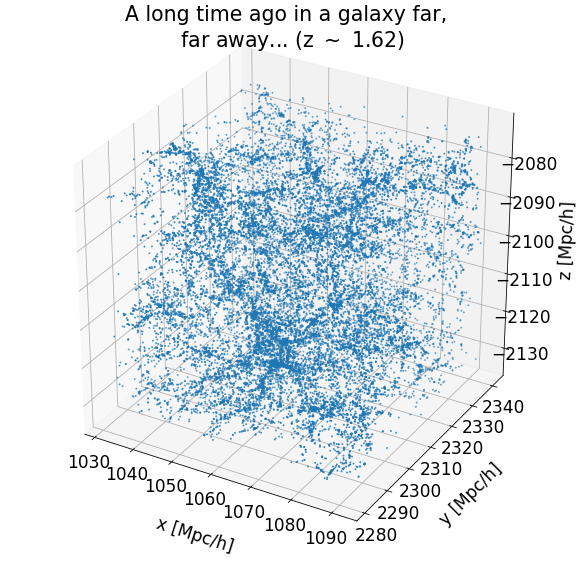

In [10]:
matplotlib.rcParams.update({'font.size': 17})

# Size of the box to display
Mpc = 30.

# Get the mean positions from the previous stat DataFrame
means = stat.collect()[1]
m_x = float(means['position_x'])
m_y = float(means['position_y'])
m_z = float(means['position_z'])

dfcut = df.filter( 
    (F.abs(df.position_x - m_x) < Mpc) &
    (F.abs(df.position_y - m_y) < Mpc) &
    (F.abs(df.position_z - m_z) < Mpc))

# Visualise it!
p = dfcut.toPandas()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(p.position_x, p.position_y, p.position_z, s=1)

ax.set_title('A long time ago in a galaxy far, \n far away... (z $\sim$ {:.2f})'.format(p.redshift.mean()))
ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
ax.set_zlabel(r'z [Mpc/h]', labelpad=20)

plt.show()

### CosmoDC2 the movie!

By copying the data to the LAL cluster, using more sophisticated tools for vizualization and projecting data on our wall-of-screens we obtain the 
following MOVIE.
Note we also colored data according to their redshift (with a colormap that is held as secret as coca-cola receipe)

In [11]:
from IPython.display import HTML

# Display video from Youtube
HTML('<iframe width="700" height="600" src="https://www.youtube.com/embed/HC_CQA5cOag" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
